In [5]:
import pickle
#with open('normalization_params.pkl','wb') as f:
#    pickle.dump({'zKum':zKum,'zKus':zKus,'rainRatem':rainRatem,'rainRates':rainRates,'dm_m':dm_m,'dm_s':dm_s, 'ind_test':ind_test},f)
#read normalization parameters
with open('normalization_params.pkl','rb') as f:
    normalization_params = pickle.load(f)
zKum = normalization_params['zKum']
zKus = normalization_params['zKus']
rainRatem = normalization_params['rainRatem']
rainRates = normalization_params['rainRates']
dm_m = normalization_params['dm_m']
dm_s = normalization_params['dm_s']
ind_test = normalization_params['ind_test']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import netCDF4 as nc
with nc.Dataset('simulated_radar_rain.nc') as ds:
    zKu=ds['zKu'][:]
    zKu_true=ds['zKu_true'][:]
    piaKu=ds['piaKu'][:]
    dm=ds['dm'][:]
    rainRate=ds['rainRate'][:]
    attKuTop=ds['attKuTop'][:]
    


In [14]:
#scripted_model = torch.jit.script(unet_model1)
#scripted_model.save("unet_dens_model.pt")
#read the model
import torch
unet_dens_model=torch.jit.load("unet_dens_model.pt")
import numpy as np
import matplotlib.pyplot as plt


X_test=((zKu[ind_test]-zKum)/zKus)[:,np.newaxis,:]

In [21]:
y_test=(np.log(1+rainRate[ind_test])-rainRatem)/rainRates
with torch.no_grad():
    yout,yout_pca=unet_dens_model(torch.tensor(X_test,dtype=torch.float32))

In [23]:
yout_numpy=yout.detach().numpy()
print(yout_numpy.shape)
print(np.corrcoef(yout_numpy[:,0,-1],y_test[:,-1]))
rain_out=np.exp(rainRates*yout_numpy[:,0,:]+rainRatem)-1
dm_out=dm_s*yout_numpy[:,1,:]+dm_m


(82500, 2, 32)
[[1.        0.5773658]
 [0.5773658 1.       ]]


In [27]:
import lkTables as lkT
lkTables=lkT.scattTables()
dnwL=[]
dmL=[]
piaKuL=[]
zKuL=[]
zKu_trueL=[]
dr=0.125
attKuTopL=[]
from bisectm import bisectm
for dm1, rainRate1 in zip(dm_out, rain_out):
    piaKu1=0.0
    zKu1=np.zeros(32)
    zKu1_true=np.zeros(32)
    rainRate1[rainRate1<0.001]=0.001
    dm1[dm1<0.5]=0.5
    for k in range(32):
        ind=bisectm(lkTables.dmr.data, 289, dm1[k])
        dnw=np.log10(rainRate1[k]/lkTables.rainRate[ind])
        dnwL.append(dnw)
        dmL.append(dm1[k])
        piaKu1+=lkTables.attKuR[ind]*10**dnw*dr
        if k==0:
            attKuTopL.append(lkTables.attKuR[ind]*10**dnw)
        zKu1[k]=lkTables.zKuR.data[ind]+10*dnw-piaKu1
        zKu1_true[k]=lkTables.zKuR.data[ind]+10*dnw
        piaKu1+=lkTables.attKuR[ind]*10**dnw*dr
    zKuL.append(zKu1)
    zKu_trueL.append(zKu1_true)
    piaKuL.append(piaKu1)


[[1.        0.9670598]
 [0.9670598 1.       ]]


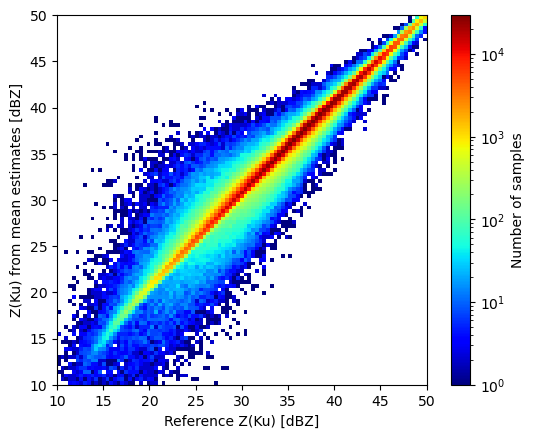

In [35]:
zKuL=np.array(zKuL)
zKu_test=zKu[ind_test]
print(np.corrcoef(zKuL[:,-1],zKu_test[:,-1]))
ax=plt.subplot(111)
h1=plt.hist2d(zKu_test[:,:].flatten(),zKuL[:,:].flatten(),bins=np.linspace(10,50,100),cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.xlabel('Reference Z(Ku) [dBZ]')
plt.ylabel('Z(Ku) from mean estimates [dBZ]')
plt.colorbar(h1[3],ax=ax,label='Number of samples')
plt.savefig('zKu_hist2d_mean.png')